# Optimistic initial values

Initial action values can be used as a simple way to encourage exploration. Suppose to set an initial estimate in a wildly optimistic way. Whichever actions are initially selected, the reward is less than the starting estimates, and the learner switches to other actions, being "disappointed" with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

In [1]:
import numpy as np

class BanditEnv:
    def __init__(self):
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [3]:
def decay_epsilon(init_value, min_value, decay_episodes, max_episodes):

    # calculate the number of the remaining episodes after the decay
    rem_episodes = max_episodes - decay_episodes
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_episodes), 'edge')
    
    return values

In [4]:
def decay_epsilon_greedy(env, init_epsilon=1, min_epsilon=0.001, decay_episodes=100, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    # Calculate the exponentially decaying epsilons. 
    epsilons = decay_epsilon(init_epsilon, min_epsilon, decay_episodes, n_episodes);
    
    for e in range(n_episodes):
        
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [5]:
def optimistic_initialization(env, optimistic_estimate=5.0,
                              initial_count=10, n_episodes=1000):
    
    # start initializing the Q-values to an optimistic value
    Q = np.full((env.size), optimistic_estimate, dtype=float)
    
    # initialize the counts that will serve as an uncertainty measure
    # the higher the more certain.
    N = np.full((env.size), initial_count, dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        
        action = np.argmax(Q)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [6]:
from tqdm import tqdm

returns_epsilon_decay = []
returns_optimistic = []

envs = []
for i in range(2000):
    envs.append(BanditEnv());

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _, _ = decay_epsilon_greedy(env=envs[i]) 
    returns_epsilon_decay.append(returns); 
    
for i in tqdm(range(2000), desc='Running optmistic method'):
    returns, _, _ = optimistic_initialization(env=envs[i])
    returns_optimistic.append(returns); 

returns_epsilon_decay = np.array(returns_epsilon_decay)
returns_optimistic = np.array(returns_optimistic)

Running epsilon decay:   0%|          | 0/2000 [00:00<?, ?it/s]

Running optmistic method: 100%|██████████| 2000/2000 [00:04<00:00, 471.44it/s]


In [7]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)
avg_reward_optimistic = np.average(returns_optimistic, axis=0)

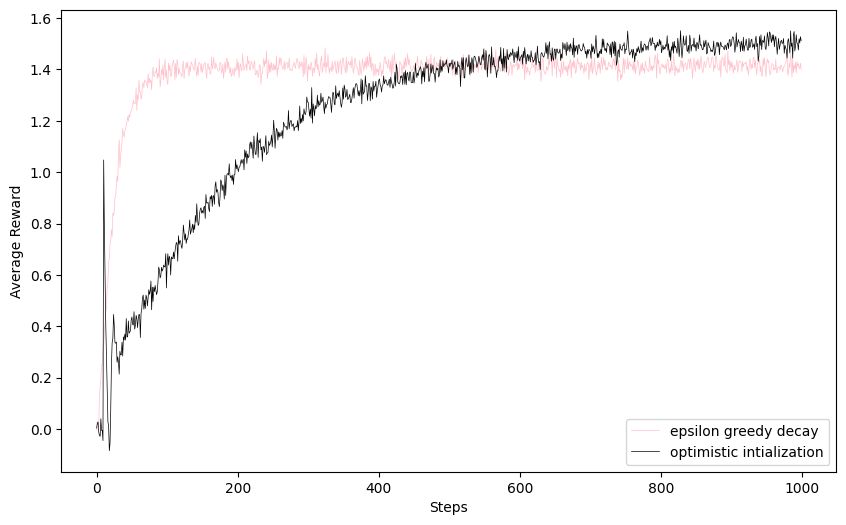

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(avg_reward_epsilon_decay, linewidth=0.5, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_optimistic, linewidth=0.5, color='black',   label='optimistic intialization')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()